In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image
import math
from sklearn.linear_model import LinearRegression
from collections import Counter

In [ ]:
"""
DEVELOPMENT NOTES:
- Algorithm is functional, but requires improvements and testing on different SCADA data sets
- The upper arm of the curve is being slightly chopped off, this needs to be addressed
"""

In [2]:
def convert_to_image(matrix,save,path):
    """
    Converts a matrix of pixels into its visual representation
    """
    data = np.zeros((matrix.shape[0], matrix.shape[1], 3), dtype=np.uint8)
    m = matrix.shape[0] # rows 
    n = matrix.shape[1] # columns
    for y in range(0,n): # for col y of n cols in matrix
            for k in range(0,m): # for row k in col y
                if matrix[k,y] == 1:
                    data[k,y] = [255,255,255]
    img = Image.fromarray(data, 'RGB')
    if save == True:
        img.save(f'{path}')
    img.show()

### Outlier detection and classification algorithm

In [386]:
class WPC_outlier_removal(object):
    """Outlier detection and removal algorithm for wind turbine power curve modelling"""
    
    def __init__(self):
        """
        Algorithm constructor
        """
        self.rules = None # The rules for classification
        self.data = None
        self.matrix = None
        self.dummy = None
        self.X_pixel_converter = None
        self.Y_pixel_converter = None
        self.result = None
        self.xmax = None
        self.ymax = None
        self.xinterval = None
        self.yinterval = None
        self.lines = None
        self.L_horizontal = None
        self.R_horizontal = None
        
    def fit(self, data: pd.DataFrame):
        """
        Fit model to data
        """
        try:
            assert data.shape[1] == 2 # Ensure size of DF is correct
        except:
            raise TypeError('Error: fit() requires a Pandas dataframe consisting of two columns only.')
        self.data = data
        self.matrix, self.xmax, self.ymax, self.xinterval, self.yinterval = self.plot_it()
        self.matrix = self.transform_image(self.matrix)
        self.matrix = self.transform_matrix(self.matrix)
        self.matrix = self.extract_objects()
        self.dummy = self.dummy_img()
        self.dummy = self.transform_image(self.dummy)
        self.X_pixel_converter, self.Y_pixel_converter = self.find_points(self.dummy)
        self.rules = self.get_boundary()
        self.lines = self.convert_to_line()
        self.lines = self.transform_image(self.lines)
        self.rules = self.find_lines(self.lines)
        self.dummy = None
        self.X_pixel_converter, self.Y_pixel_converter = None, None
    
    def convert_to_line(self):
        """
        Converts the rules into a line plot and returns the graphic as a matrix
        """
        self.rules = self.rules[(self.rules['LH']>=0)&(self.rules['RH']>=0)&(self.rules['Y']>=0)]
        plt.figure(figsize=(20,15))
        plt.gcf().set_facecolor('white')
        plt.plot(self.rules['LH'],self.rules['Y'],c='black')
        plt.plot(self.rules['RH'],self.rules['Y'],c='black')
        plt.xticks(np.arange(0,self.xmax,self.xinterval),c='black')
        plt.yticks(np.arange(0,self.ymax,self.yinterval),c='black')
        plt.ylim(-int(self.yinterval),self.ymax)
        plt.xlim(-int(self.xinterval),self.xmax)
        plt.savefig('temp_dummy.png', format='png')
        self.lines = imread('temp_dummy.png')
        plt.clf()
        return self.lines
    
    def find_lines(self,graph):
        """
        Finds the plotted lines and creates rules around their position
        """
        y_min, y_max, x_min, x_max = self.rules['Ypx'].min(),self.rules['Ypx'].max(),self.rules['LHPx'].min(), self.rules['RHPx'].max()
        objects = []
        for k in range(y_min,y_max+20):
            act, row = False, []
            for y in range(x_min-20,x_max+20):
                if graph[k,y] == 1 and act == False:
                    act = True
                    row.append([y])
                elif graph[k,y] == 0 and act == True:
                    act = False
            objects.append(row)
        rules = {'Y':[],
                'LX': [],
                'RX': []}
        for i,row in enumerate(objects):
            if row != []:
                rules['Y'].append(y_min+i)
                rules['LX'].append(row[0])
                rules['RX'].append(row[1])
        self.rules = pd.DataFrame(rules,index=None)
        self.rules['LX'] = self.X_pixel_converter.predict(np.array(self.rules['LX'].values.tolist()).reshape(-1,1))
        self.rules['RX'] = self.X_pixel_converter.predict(np.array(self.rules['RX'].values.tolist()).reshape(-1,1))
        self.rules['Y'] = self.Y_pixel_converter.predict(np.array(self.rules['Y'].values.tolist()).reshape(-1,1))
        self.rules['LX'] = self.rules['LX'].round(decimals=1)
        self.rules['RX'] = self.rules['RX'].round(decimals=1)
        self.rules['Y'] = self.rules['Y'].round(decimals=1)
        self.rules = self.rules[(self.rules['Y']>=0)&(self.rules['LX']>=0)&(self.rules['RX']>=0)]
        return self.rules
    
    def get_boundary(self):
        """
        Finds the boundary of the normal data points and creates a rule set based on this
        """
        # Extract starting points horizontally from left
        self.L_horizontal = []
        for k in range(0,self.matrix.shape[0]):
            val = 0
            for y in range(0,self.matrix.shape[1]):
                if self.matrix[k,y] == 1:
                    val = y+4
                    break
            self.L_horizontal.append(val)
        # Extract starting points horizontally from right
        self.R_horizontal = []
        for k in range(0,self.matrix.shape[0]):
            val = 0
            for y in range(self.matrix.shape[1]-1,0,-1):
                if self.matrix[k,y] == 1:
                    val = y-4
                    break
            self.R_horizontal.append(val)
        
        self.rules = pd.DataFrame({'LHPx':self.L_horizontal,'RHPx':self.R_horizontal},index=None)
        self.rules['Ypx'] = self.rules.index
        self.rules['LH'] = self.X_pixel_converter.predict(np.array(self.rules['LHPx'].values.tolist()).reshape(-1,1))
        self.rules['RH'] = self.X_pixel_converter.predict(np.array(self.rules['RHPx'].values.tolist()).reshape(-1,1))
        self.rules['Y'] = self.Y_pixel_converter.predict(np.array(self.rules.index.values.tolist()).reshape(-1,1))
        self.rules['LH'] = self.rules['LH'].round(decimals=1)
        self.rules['RH'] = self.rules['RH'].round(decimals=1)
        self.rules['Y'] = self.rules['Y'].round(decimals=1)
        return self.rules
    
    def dimension_count(self,k,y_range,count,finish,graph):
        """
        Recursively works to find out the size of the plotted points
        """
        if k+1 >= graph.shape[0]:
            finish == True
        if np.sum(graph[k+1,y_range[0]:y_range[1]+1]) == y_range[1]-y_range[0] and finish == False:
            count += 1
            count, finish = self.dimension_count(k+1,y_range,count,finish,graph)
        else:
            finish = True
        if  finish == True:
            finish = True
            return count, finish
    
    def most_common(self,L):
        """
        Finds the most common item in a list
        """
        set_L = Counter(L)
        return max(set_L)  
    
    def find_point_shape(self,graph):
        """
        Finds out shape of the plotted points 
        """
        y_bound, k_bound = [],[]
        for y in range(0,graph.shape[1]):
            if graph[round(graph.shape[0]/2),y] == 1:
                y_bound.append(y)
        for k in range(graph.shape[0]-1,0,-1):
            if graph[k,round(graph.shape[1]/2)] == 1:
                k_bound.append(k)
        shapes, last = [], []
        for k in range(k_bound[1]+5,k_bound[0]-5):
            for y in range(y_bound[0]+5,y_bound[1]-5):
                if graph[k,y]==1:
                    check = 0
                    if last != []:
                        if k in [x for x in range(last[0],last[1]+1)]:
                            check +=1 
                        if y in [x for x in range(last[2],last[3]+1)]:
                            check +=1
                    if check <2:
                        count = 0
                        for y2 in range(y,graph.shape[1]-1):
                            if graph[k,y2] == 1:
                                count+=1
                            else:
                                break
                        y_range = [y,y+count]
                        count, _ = self.dimension_count(k,y_range,1,False,graph)
                        dim = (y_range[1]-y_range[0],count)
                        if dim[1] > 4 and dim[0] > 4:
                            last = [k,k+dim[0],y,y+dim[1]]
                            shapes.append(dim)
        shape = self.most_common(shapes)
        return shape
    
    def find_points(self,graph):
        """
        Finds the plotted points on the image and then trains two regression models to
        convert pixel to unit values
        """
        shape = self.find_point_shape(graph)
        area, points = shape[0]*shape[1], []
        # scan for data points
        for y in range(0,graph.shape[1]):
            if y+shape[1] > graph.shape[1]-1 or y-shape[1] <0:
                pass
            else:
                for k in range(0,graph.shape[0]):
                    if k+shape[0] > graph.shape[0]-1 or k-shape[0]<0:
                        pass
                    elif np.sum(graph[k-(shape[0]//2):k+round(shape[0]/2)+1,y-(shape[1]//2):y+round(shape[1]/2)+1]) == area:
                        points.append([k,y])
        # get coords for each unit on x/y axis
        k_units = sorted(set([x[0] for x in points]),reverse=True)
        y_units = sorted(set([x[1] for x in points]),reverse=False)
        # create functions to map pixels to units
        X = np.array(y_units).reshape(-1,1)
        y = [x*self.xinterval for x in range(0,len(y_units))]
        self.X_pixel_converter = LinearRegression()
        self.X_pixel_converter.fit(X,y)
        X = np.array(k_units).reshape(-1,1)
        y = [x*self.yinterval for x in range(0,len(k_units))]
        self.Y_pixel_converter = LinearRegression()
        self.Y_pixel_converter.fit(X,y)
        return self.X_pixel_converter,self.Y_pixel_converter  
    
    def dummy_img(self):
        """
        Creates a new matrix to plot points at first 4 intervals. Creates a plot graphic which
        is then used to compute the pixel to unit regression
        """
        self.dummy = self.data.iloc[0:7,:].copy()
        # Vertical axis points
        self.dummy.iloc[0,0] = 0
        self.dummy.iloc[0,1] = 0
        self.dummy.iloc[1,0] = 0
        self.dummy.iloc[1,1] = self.xinterval
        self.dummy.iloc[2,0] = 0
        self.dummy.iloc[2,1] = self.xinterval*2
        self.dummy.iloc[3,0] = 0
        self.dummy.iloc[3,1] = self.xinterval*3
        # Horizontal axis points
        self.dummy.iloc[4,0] = self.yinterval
        self.dummy.iloc[4,1] = 0
        self.dummy.iloc[5,0] = self.yinterval*2
        self.dummy.iloc[5,1] = 0
        self.dummy.iloc[6,0] = self.yinterval*3
        self.dummy.iloc[6,1] = 0
        # Create the plot graphic
        plt.figure(figsize=(20,15))
        plt.gcf().set_facecolor('white')
        plt.scatter(self.dummy.iloc[:,1],self.dummy.iloc[:,0],marker='s',s=50,c='black')
        plt.xticks(np.arange(0,self.xmax,self.xinterval),c='black')
        plt.yticks(np.arange(0,self.ymax,self.yinterval),c='black')
        plt.ylim(-int(self.yinterval),self.ymax)
        plt.xlim(-int(self.xinterval),self.xmax)
        plt.savefig('temp_dummy.png', format='png')
        self.dummy = imread('temp_dummy.png')
        plt.clf()
        return self.dummy
        
    
    def plot_it(self):
        """
        Plots the data to create the graphic needed for rule making    
        """
        # set the axis limits
        self.xmax = round(math.ceil(self.data.iloc[:,0].max())*1.1)
        self.ymax = round(math.ceil(self.data.iloc[:,1].max())*1.1)
        os = '1'+'0'*(len(str(self.xmax))-1)
        self.xinterval = 0.1*int(os) 
        os = '1'+'0'*(len(str(self.ymax))-1)
        self.yinterval = 0.1*int(os)
        # create a plot
        plt.figure(figsize=(20,15))
        plt.gcf().set_facecolor('white')
        plt.scatter(self.data.iloc[:,0],self.data.iloc[:,1],marker='s',s=10,c='black')
        plt.xticks(np.arange(0,self.xmax,self.xinterval),c='black')
        plt.yticks(np.arange(0,self.ymax,self.yinterval),c='black')
        plt.ylim(-self.yinterval,self.ymax)
        plt.xlim(-self.xinterval,self.xmax)
        plt.savefig('temp.png', format='png')
        self.matrix = imread('temp.png')
        plt.clf()
        return self.matrix, self.xmax, self.ymax, self.xinterval, self.yinterval
    
    def transform_image(self,matt):
        """
        Takes the png matrix and turns it into a 2D matrix
        """
        # process into 2D array
        matt = matt[:,:,0]
        matt = np.where(matt <1,1,0)
        return matt
    
    def transform_matrix(self,mat):
        """
        Initiates the cleaning phase on the matrix, first the vertical phase, then horizontal
        """
        m, n = mat.shape[0], mat.shape[1]
        # vertical cleaning phase
        for y in range(0,n): # for col y of n cols in matrix
            act, y_cis = False, []
            for k in range(0,m): # for row k in col y
                if mat[k,y] == 1 and act == False: # if pixel isn't white
                    s, act = k, True # start point of interval
                elif mat[k,y] == 0 and act == True:
                    e, act = k-1, False # end point of interval
                    y_cis.append((s,e)) # append ci to col cis
            dbest = [u[1]-u[0] for u in y_cis] # create list of intervals
            if dbest != []:
                check = max(dbest)
                dbest = dbest.index(check) # find index of best ci
                Ubest = y_cis[dbest] # Ubest is the best y_cis
                # transform column k
                mat[:,y] = 1
                mat[Ubest[0]:,y] = 0
                mat[Ubest[1]:,y] = 1
            else:
                mat[:,y] = 1
        # horizontal cleaning phase
        for k in range(0,m): # for col y of n cols in matrix
            act, x_cis = False, []
            for y in range(0,n): # for row k in col y
                if mat[k,y] == 0 and act == False: # if pixel isn't white
                    s, act = y, True # start point of interval
                elif mat[k,y] == 1 and act == True:
                    e = y-1 # end point of interval
                    x_cis.append((s,e)) # append ci to col cis
                    act = False
            dbest = [u[1]-u[0] for u in x_cis] # create list of intervals
            if dbest != []:
                check = max(dbest)
                dbest = dbest.index(check) # find index of best ci
                Ubest = x_cis[dbest] # Ubest is the best x_cis
                # transform column k
                mat[k,:] = 1
                mat[k,Ubest[0]:] = 0
                mat[k,Ubest[1]:] = 1
            else:
                mat[k,:] = 1
        return mat
    
    def collection_count(self,objects,y_range,index,count,finish=False):
        """
        Recursively counts how many objects per row connect as one big object
        """
        if index+1 == len(objects) or finish == True:
            finish = True
            return count
        for obj in objects[index+1]:
            obj_r = [x for x in range(obj[0],obj[1]+1)]
            if bool(set(y_range) & set(obj_r)) == True:
                count+=1
                count = self.collection_count(objects,obj_r,index+1,count,finish)
        return count    

    def prune_objects(self,objects,y_range,index,finish=False):
        """
        Prunes objects until only the biggest object remains
        """
        if finish == True:
            return objects
        for obj in objects[index]:
            obj_r = [x for x in range(obj[0],obj[1]+1)]
            if bool(set(y_range) & set(obj_r)) == False:
                objects[index].pop(obj)
        if index+1 == len(objects):
            finish = True
            return objects
        elif objects[index+1] == []:
            finish = True
            return objects
        else:
            y_range = [x for x in range(objects[index][0],objects[index][1]+1)]
            self.prune_objects(objects,y_range,index+1,finish)       

    def extract_objects(self):
        """
        Extracts locations for all objects from the matrix
        """
        objects = []
        # Extract all objects
        for k in range(0,self.matrix.shape[0]):
            obj_in_row, act = [], False
            for y in range(0,self.matrix.shape[1]):
                if self.matrix[k,y] == 0 and act == False:
                    s, act = y, True
                elif self.matrix[k,y] == 1 and act == True:
                    e, act = y-1, False
                    obj_in_row.append([s,e])
            objects.append(obj_in_row)
        # for each object captured, find out how many connections across K
        for i,row in enumerate(objects): # objects belonging to row K
            if len(row)>=1: # only K rows with 1+ object accepted
                for obj in row: # for each object on row K
                    obj_s = [x for x in range(obj[0],obj[1]+1)] # acquire y values for object
                    obj.append(self.collection_count(objects,obj_s,i,0))
        # Find best object with highest collection
        best, y_best, k_best = 0,0,0
        for yth,row in enumerate(objects):
            for kth,obj in enumerate(row):
                if obj[2] > best:
                    best = obj[2]
                    y_best, k_best = yth, kth
        for row in range(0,len(objects[:y_best])):
            objects[row] = []
        for row in range(1,len(objects[y_best+best:])):
            objects[row+best+y_best] = []
        objects = self.prune_objects(objects,
                                [x for x in range(objects[y_best][k_best][0],objects[y_best][k_best][1]+1)],
                                  k_best,finish=False)
        
        # Now transform the matrix to only contain the object
        for k,row in zip(range(0,self.matrix.shape[0]),objects):
            if row == []:
                self.matrix[k,:] = 0
            else:
                y_range = [x for x in range(row[0][0],row[0][1]+1)]
                for y in range(0,self.matrix.shape[1]):
                    if y not in y_range:
                        self.matrix[k,y] = 0
                    else:
                        self.matrix[k,y] = 1
        return self.matrix
    
    def predict(self, data: pd.DataFrame):
        """
        Classifies the data as normal (0) or outlier (1) based on rules created during fitting 
        """
        try:
            assert data.shape[1] == 2
        except:
            raise TypeError('Error: transform() requires a Pandas dataframe consisting of two columns only.')
        data_copy_X_val, data_copy_Y_val = data.iloc[:,0].round(decimals=1).values, data.iloc[:,1].round(decimals=1).values
        data_copy_class = [1 for x in range(0,data.shape[0])]
        y_max = self.rules['Y'].max()
        for i in range(0,data.shape[0]):
            Y, X = data_copy_Y_val[i], data_copy_X_val[i]
            if Y > y_max or Y < 0:
                data_copy_class[i] = 1
            else:
                # find closest rule to Y
                to_compare = self.rules[(self.rules['Y']>=Y-(self.yinterval*2))&
                                        (self.rules['Y']<=Y+(self.yinterval*2))]
                compare = [abs(Y-v) for v in to_compare['Y'].values]
                index = compare.index(min(compare))
                x_max, x_min = to_compare.iloc[index,2], to_compare.iloc[index,1]
                if Y > y_max or Y < 0:
                    data_copy_class[i] = 1
                elif data_copy_X_val[i] <= x_max and data_copy_X_val[i] >= x_min:
                    data_copy_class[i] = 0
        data['class'] = data_copy_class
        self.result = data
        return data
    
    
    def isolate(self, data: pd.DataFrame):
        """
        Transforms a dataset by removing all but the outliers
        """
        data = data[data.iloc[:,-1]==0].reset_index(drop=True)
        return data
            
    def show_scatter(self,decision_boundary: bool,normal:bool,outliers: bool):
        """
        Shows a scatter plot of the data with the normal instances present and optionally the outliers
        """
        plt.figure(figsize=(20,15))
        plt.gcf().set_facecolor('0.8')
        if outliers == True:
            plt.scatter(self.result.iloc[:,0][self.result['class']==1],self.result.iloc[:,1][self.result['class']==1],marker='.',s=30,c='red',label='Outliers')
        if normal == True:
            plt.scatter(self.result.iloc[:,0][self.result['class']==0],self.result.iloc[:,1][self.result['class']==0],marker='.',s=30,c='black',label='Normal')
        if decision_boundary == True:
            plt.plot(self.rules.iloc[:,1],self.rules.iloc[:,0],c='yellow',lw=2,label='Decision boundary')
            plt.plot(self.rules.iloc[:,2],self.rules.iloc[:,0],c='yellow',lw=2)
        plt.title('Anomaly Detection Algorithm Towards Modelling Wind Power Curves')
        plt.xlabel('Wind Speed (m/s)')
        plt.ylabel('LV ActivePower (kW)')
        plt.legend()
        plt.grid()
        plt.show()

### Testing the algorithm using SCADA data from a wind turbine in Turkey

In [382]:
# Import the data
# Datasource: https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset
raw_data = pd.read_csv("D:/Birkbeck/Final Project/Datasets/SHORTLIST/Wind Turbine Scada Dataset/T1.csv/T1.csv")

In [383]:
# Data preparation
raw_data = raw_data.iloc[:,1:3]
raw_data = raw_data[['Wind Speed (m/s)','LV ActivePower (kW)']]

--- 16.431594848632812 seconds ---
--- 23.427359580993652 seconds ---


<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

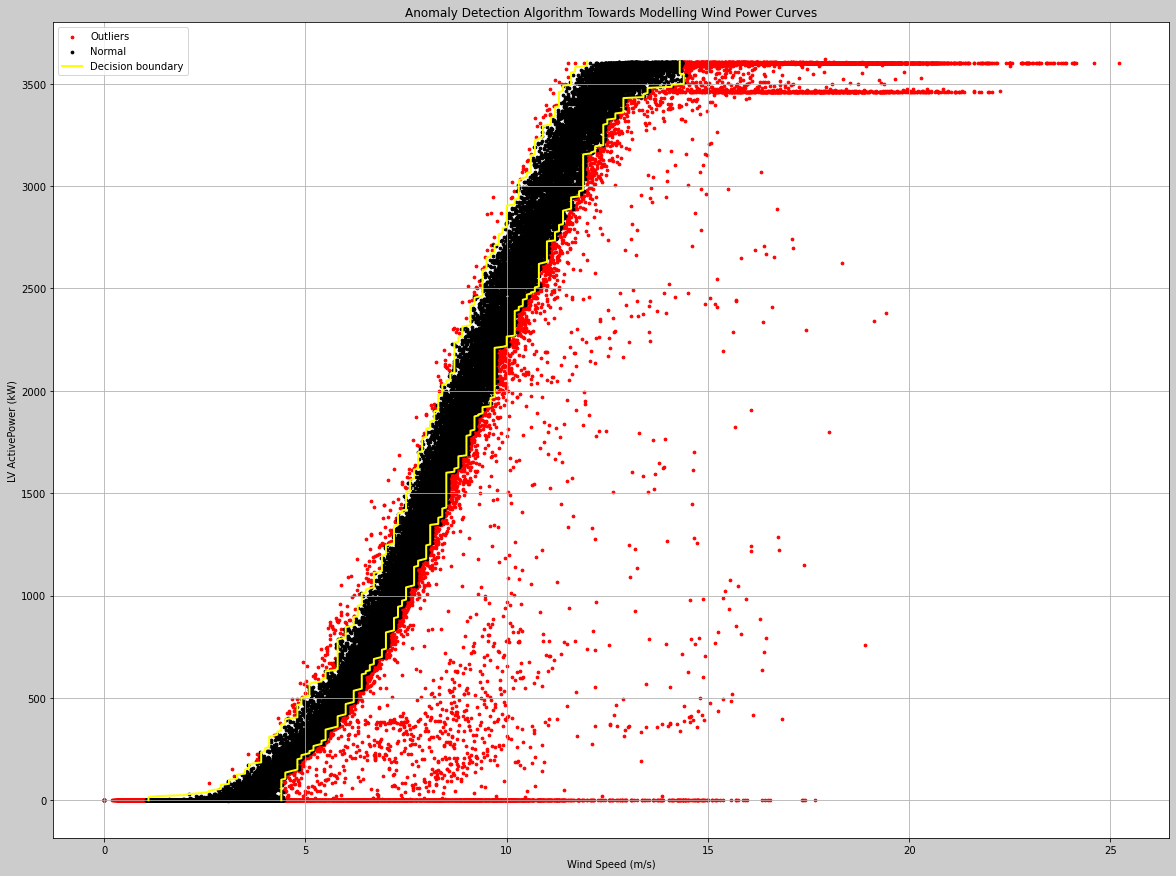

--- 0.5424869060516357 seconds ---


In [394]:
import time
# Fitting the model
start_time = time.time()
ALG = WPC_outlier_removal()
ALG.fit(raw_data)
print("--- %s seconds ---" % (time.time() - start_time))
# Transforming / classifying the data
testdata = raw_data.copy()
start_time = time.time()
testdata = ALG.predict(testdata)
print("--- %s seconds ---" % (time.time() - start_time))
# Plotting the results
start_time = time.time()
ALG.show_scatter(True,True,True)
print("--- %s seconds ---" % (time.time() - start_time))

### Modelling the power curve with a radial basis SVM

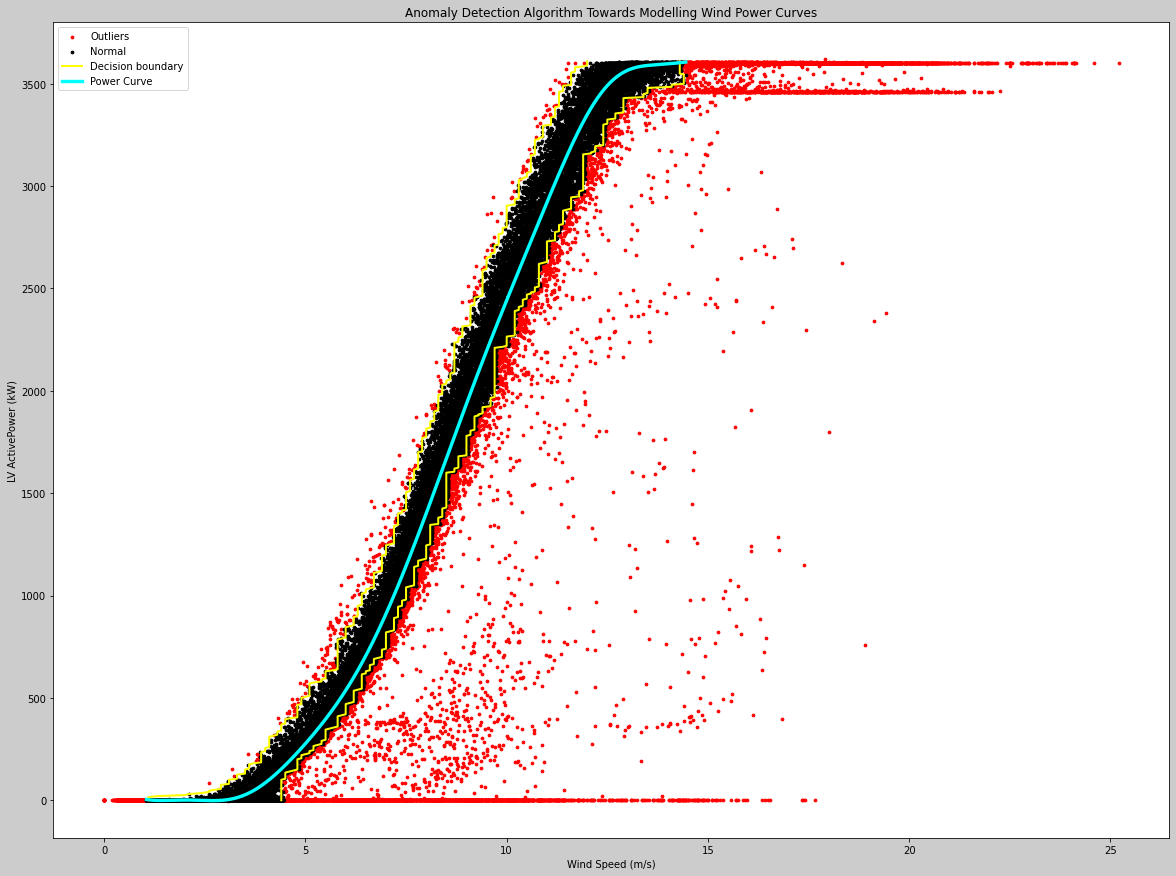

In [411]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(testdata[testdata['class']==0].iloc[:,:-1])
test_data_prep = scaler.transform(testdata[testdata['class']==0].iloc[:,:-1])
# Split into X y
X = test_data_prep[:,0].reshape(-1,1)
y = test_data_prep[:,1]
# Fitting and predictions
SVM = SVR(kernel='rbf',C=29,gamma="scale", epsilon=0)
SVM = SVM.fit(X,y)
tpredictions = SVM.predict(X)
print("Mean Absolute Error:",str(mean_absolute_error(y,tpredictions)))
# Prepare and inverse scale data
d = {'X':X.reshape(X.shape[0],),
    'y':y.reshape(y.shape[0],)}
ds = scaler.inverse_transform(pd.DataFrame(d))
ds = pd.DataFrame(ds)
t = {'X':X.reshape(X.shape[0],),
    'tp':tpredictions.reshape(tpredictions.shape[0],)}
ts = scaler.inverse_transform(pd.DataFrame(t))
ts = pd.DataFrame(ts).sort_values(by=[0])
# Plot results
plt.figure(figsize=(20,15))
plt.gcf().set_facecolor('0.8')
plt.scatter(ALG.result.iloc[:,0][ALG.result['class']==1],ALG.result.iloc[:,1][ALG.result['class']==1],marker='.',s=30,c='red',label='Outliers')
plt.scatter(ALG.result.iloc[:,0][ALG.result['class']==0],ALG.result.iloc[:,1][ALG.result['class']==0],marker='.',s=30,c='black',label='Normal')
plt.plot(ALG.rules.iloc[:,1],ALG.rules.iloc[:,0],c='yellow',lw=2,label='Decision boundary')
plt.plot(ALG.rules.iloc[:,2],ALG.rules.iloc[:,0],c='yellow',lw=2)
plt.plot(ts[0],ts[1],c='cyan',label='Power Curve',lw=3.4)
plt.title('Anomaly Detection Algorithm Towards Modelling Wind Power Curves')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.legend()
plt.show()